# 1. Prepare the environment

In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )


# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]

NumPy 1.26.4

Matplotlib 3.9.0

TensorFlow 2.16.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# 2. Load the pretrained model

In [3]:
# Load the ImageNet ResNet50 model, including both the feature extractor part and the classifier part
model = tf.keras.applications.ResNet50(include_top=True, weights="imagenet")
model.summary()

2024-07-01 22:42:04.375178: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-01 22:42:04.375212: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-01 22:42:04.375222: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-01 22:42:04.375479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-01 22:42:04.375512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

# 3. Use the pretrained model

type(img) = <class 'PIL.Image.Image'>
type(x) = <class 'numpy.ndarray'> , x.dtype = float32 , x.shape = (224, 224, 3) , min(x) = 0.0 , max(x) = 255.0


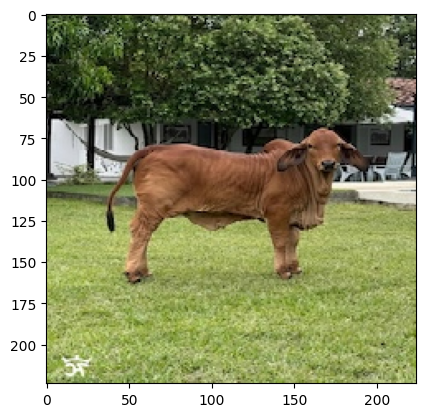

In [4]:
# Load an image as PIL.Image.Image
img_path = '/Users/Lemon/workspace/Projects/HW/Resize/B_100.jpeg'
#img = model.utils.load_img(img_path, target_size=(224, 224))  
img =  tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
print( f"type(img) = {type(img)}" )

# Convert PIL Image to NumPy ndarray
x = tf.keras.preprocessing.image.img_to_array(img)
print( f"type(x) = {type(x)} , x.dtype = {x.dtype} , x.shape = {x.shape} , min(x) = {np.min(x)} , max(x) = {np.max(x)}" )

# Display the NumPy image
plt.imshow( x.astype(np.uint8) )
plt.show()

In [5]:
# Preprocess the image following requirements of resnet50
x = tf.keras.applications.resnet.preprocess_input(x)

print( f"type(x) = {type(x)} , x.dtype = {x.dtype} , x.shape = {x.shape} , min(x) = {np.min(x):.4f} , max(x) = {np.max(x):.4f}" )

type(x) = <class 'numpy.ndarray'> , x.dtype = float32 , x.shape = (224, 224, 3) , min(x) = -123.6800 , max(x) = 151.0610


In [6]:
# Use the model to predict this image
#pred = model.predict( np.expand_dims(x, axis=0) )
pred = model.predict( np.expand_dims(x, axis=0) )

# Decode the top 10 classes
predictions = tf.keras.applications.resnet.decode_predictions(pred, top=10)[0]
for i, prediction in enumerate(predictions):
  print( f"Rank {i+1}: {prediction}" )


2024-07-01 22:42:27.900491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rank 1: ('n02088094', 'Afghan_hound', 0.6509967)
Rank 2: ('n02403003', 'ox', 0.08312825)
Rank 3: ('n02389026', 'sorrel', 0.07668848)
Rank 4: ('n02087394', 'Rhodesian_ridgeback', 0.045040973)
Rank 5: ('n02102480', 'Sussex_spaniel', 0.026709167)
Rank 6: ('n02111277', 'Newfoundland', 0.01894883)
Rank 7: ('n02108422', 'bull_mastiff', 0.01801645)
Rank 8: ('n02111129', 'Leonberg', 0.015703546)
Rank 9: ('n02088466', 'bloodhound', 0.01402257)
Rank 10: ('n03868242', 'oxcart', 0.00523651)
